In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10702652846214539414]

In [4]:
df = pd.read_csv('data/medibloc(2018~2021).csv', encoding='cp949')
df.tail()

,날짜,시가,고가,저가,종가,거래량,시가총액
1090,30-Mar-21,102.73,119.43,102.72,111.63,"\229,362,666,554","\305,655,135,725"
1091,31-Mar-21,112.61,140.07,109.94,130.17,"\503,803,529,611","\356,424,611,490"
1092,01-Apr-21,130.17,277.06,127.18,273.11,"\2,256,586,556,340","\747,797,814,365"
1093,02-Apr-21,267.53,398.55,267.53,298.93,"\1,629,150,393,198","\818,506,251,680"
1094,03-Apr-21,299.90,327.75,272.89,286.96,"\586,518,672,303","\785,724,654,933"


In [5]:
# 당일 중간가격 구하기
high_prices = df['고가'].values
low_prices = df['저가'].values
mid_prices = (high_prices+low_prices)/2 

In [6]:
# 최근 30일을 기준으로 다음날 가격을 예측
seq_len = 30
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

In [7]:
# 정규화
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

In [8]:
# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((958, 30, 1), (106, 30, 1))

In [9]:
# LSTM  모델구현

model = Sequential()

model.add(LSTM(255, return_sequences=True, input_shape=(30, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(64, activation='relu'))

model.add(Dense(32, activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 255)           262140    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                81920     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 350,333
Trainable params: 350,333
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Early Stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                       patience=10,
                                       verbose=1,
                                       mode='auto')

In [11]:
history = model.fit(x_train, y_train,
                validation_data=(x_test, y_test),
                batch_size=10,
                epochs=100,
                callbacks=es)

Epoch 1/100
96/96 [==============================] - 8s 47ms/step - loss: 0.0537 - val_loss: 7.4558
Epoch 2/100
96/96 [==============================] - 2s 20ms/step - loss: 0.0188 - val_loss: 6.3215
Epoch 3/100
96/96 [==============================] - 2s 20ms/step - loss: 0.0099 - val_loss: 4.6322
Epoch 4/100
96/96 [==============================] - 2s 19ms/step - loss: 0.0082 - val_loss: 4.1007
Epoch 5/100
96/96 [==============================] - 2s 20ms/step - loss: 0.0059 - val_loss: 4.0323
Epoch 6/100
96/96 [==============================] - 2s 20ms/step - loss: 0.0056 - val_loss: 5.2659
Epoch 7/100
96/96 [==============================] - 2s 20ms/step - loss: 0.0048 - val_loss: 4.4529
Epoch 8/100
96/96 [==============================] - 2s 20ms/step - loss: 0.0047 - val_loss: 3.8775
Epoch 9/100
96/96 [==============================] - 2s 20ms/step - loss: 0.0045 - val_loss: 4.8648
Epoch 10/100
96/96 [==============================] - 2s 20ms/step - loss: 0.0042 - val_loss: 3.7145

In [12]:
model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 18ms/step - loss: 4.2061


4.206089973449707

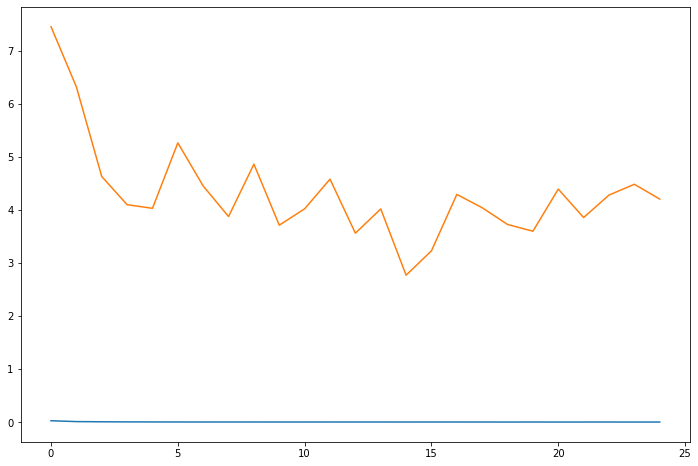

In [13]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.plot(history.history['mae'])
# plt.plot(history.history['val_mae'])
plt.show()

In [14]:
pred = model.predict(x_test)

In [15]:
y_test[67]

1.62729912875121

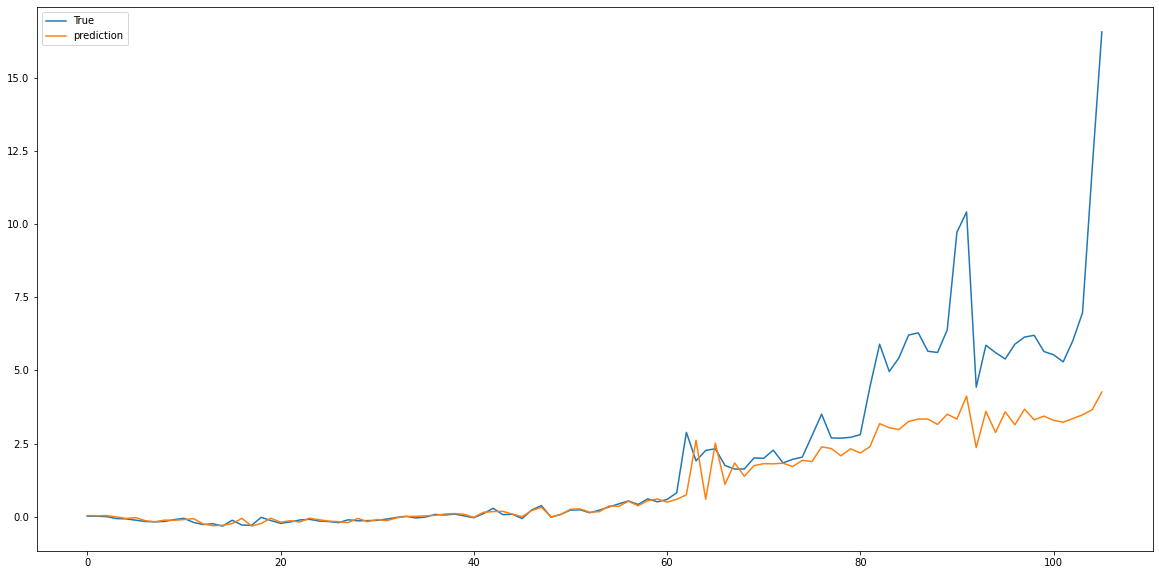

In [16]:
fig = plt.figure(facecolor='white',figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.plot(y_test,label='True')
ax.plot(pred, label='prediction')
ax.legend()
plt.show()